# Setup

## Colab

In [1]:
# # # Mount the drive and move to dir
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Switch to current dir
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the utilities and the dataloader
from utils import trainutil, inferutil, setuputil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)

# Import the funcs needed from utils
from utils.setuputil import setup_config, display_config
from utils.trainutil import train_unified
from utils.inferutil import infer_one, infer_full, binfer_one, binfer_full

## Configuration

In [3]:
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "BertCasedPooler",
    "model_base": "bert-base-cased",
    # System Configuration
    "device": "cuda:0",
    "threads": 10,
    "seed": 0,
    # Data Configuration
    "data_dir": "../data",
    "data_ds": "50",
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 32,
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 64,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 256,
    # Training Parameters
    "batch_size": 20,
    "lr": 1e-2,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 0,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:08<00:00,  4.53it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 5889.22it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 2434.87it/s]



5(P) = 5(G) + 0(E)
{
  "env": "colab",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 10,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertCasedPooler",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "50",
  "data_dir": "../data",
  "train_dir": "../data/50_train",
  "val_dir": "../data/50_val",
  "test_dir": "../data/50_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 64,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 256,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 20,
  "lr": 0.01,
  "mu": 0.25,
  "epochs": 10,
  "patience": 2,
  "save_int": 0,
  

# Model Creation

In [4]:
from transformers import BertModel, BertConfig
import torch.nn as nn
import torch
import math
from tqdm import tqdm


class SimpleBertEmbedAvg(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Define all params from config
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["hidden_size"]
        self.intermediate_size = config["intermediate_size"]
        self.num_hidden_layers = config["num_hidden_layers"]
        self.num_attention_heads = config["num_attention_heads"]
        self.hidden_act = config["hidden_act"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]
        self.attention_probs_dropout_prob = config["attention_probs_dropout_prob"]
        self.max_position_embeddings = config["max_position_embeddings"]
        self.type_vocab_size = config["type_vocab_size"]
        self.layer_norm_eps = config["layer_norm_eps"]
        self.initializer_range = config["initializer_range"]
        self.pad_token_id = config["pad_token_id"]
        self.gradient_checkpointing = config["gradient_checkpointing"]

        # Setup config with all params
        self.config = BertConfig(
            vocab_size=self.vocab_size,
            hidden_size=self.hidden_size,
            num_hidden_layers=self.num_hidden_layers,
            num_attention_heads=self.num_attention_heads,
            intermediate_size=self.intermediate_size,
            hidden_act=self.hidden_act,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=self.attention_probs_dropout_prob,
            max_position_embeddings=self.max_position_embeddings,
            type_vocab_size=self.type_vocab_size,
            layer_norm_eps=self.layer_norm_eps,
            initializer_range=self.initializer_range,
            pad_token_id=self.pad_token_id,
            gradient_checkpointing=self.gradient_checkpointing,
        )

        # Create BERT model from scratch (no pretrained weights)
        self.bert = BertModel(self.config)

        # Simple classification head with dropout from config
        self.dropout = nn.Dropout(self.hidden_dropout_prob)
        self.gelu = nn.GELU()
        self.classifier = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        batch_size, rows, cols, seq_len = input_ids.shape
        S_cube = torch.zeros((batch_size, rows, cols), device=input_ids.device)

        # Process each cell with progress bar
        for cell in range(rows * cols):
            row = cell // cols
            col = cell % cols

            # Simple forward pass
            outputs = self.bert(
                input_ids=input_ids[:, row, col, :],
                attention_mask=attention_mask[:, row, col, :],
            )

            pooled = self.dropout(outputs.pooler_output)
            activated = self.gelu(pooled)
            logits = self.classifier(activated)
            S_cube[:, row, col] = logits.squeeze(-1)

        return S_cube

In [5]:
# 1) Create model and move to GPU Observe its architecture - 440 Mib
untrained_model = SimpleBertEmbedAvg(config).to(DEVICE)
print(untrained_model)

SimpleBertEmbedAvg(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 64, padding_idx=0)
      (position_embeddings): Embedding(64, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
   

# Model Training

In [6]:
# Train with adjusted batch size
trained_model = train_unified(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.38s/it]


Train Loss: 1.5055439472198486, Perplexity: 1.0000301113322814
Val Loss: 1.8992317914962769, Perplexity: 1.0000379853572554


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.86s/it]


Train Loss: 1.4375147819519043, Perplexity: 1.0000287507089327
Val Loss: 1.6616936922073364, Perplexity: 1.0000332344260954


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.90s/it]


Train Loss: 1.219355821609497, Perplexity: 1.0000243874138004
Val Loss: 0.8556357622146606, Perplexity: 1.0000171128616677


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.88s/it]


Train Loss: 0.6595983356237411, Perplexity: 1.0000131920537267
Val Loss: 0.48445388674736023, Perplexity: 1.0000096891246741


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.02s/it]


Train Loss: 0.38682012259960175, Perplexity: 1.000007736432378
Val Loss: 0.32714730501174927, Perplexity: 1.0000065429675054


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.84s/it]


Train Loss: 0.300503745675087, Perplexity: 1.000006010092974
Val Loss: 0.261694073677063, Perplexity: 1.0000052338951704


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.82s/it]


Train Loss: 0.2582347244024277, Perplexity: 1.0000051647078252
Val Loss: 0.32963550090789795, Perplexity: 1.00000659273175


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.90s/it]


Train Loss: 0.22013822942972183, Perplexity: 1.0000044027742807
Val Loss: 0.37049853801727295, Perplexity: 1.0000074099982141


EARLY STOPPING at epoch 7, best epoch 5
Train Loss = 0.300503745675087, Perplexity = 1.000006010092974
Val Loss = 0.261694073677063, Perplexity = 1.0000052338951704


TRAINING DONE at epoch 7, best epoch 5
Train Loss = 0.300503745675087, Perplexity = 1.000006010092974
Val Loss = 0.261694073677063, Perplexity = 1.0000052338951704



Filename: ../data/50_train/5%20ORD-013745%20CTD%20Chemical-gene%20interactions.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,0): 0.94071388244628906250
(2,4): 0.94071692228317260742
(2,6): 0.94072979688644409180
(2,1): 0.94073718786239624023
(2,3): 0.94074010848999023438
(2,5): 0.94074666500091552734
(2,2): 0.94075036048889160156
(2,0): 0.94075500965118408203

NB to B ratio: Predicted = 9938:62 | Actual = 9992:8
Accuracy: 99.46% | Precision: 12.90% | Recall: 100.00% | F1-Score: 0.23



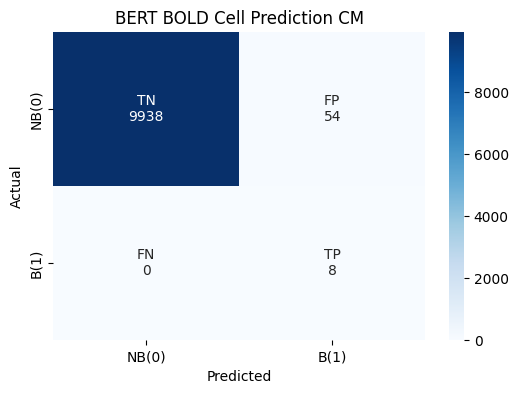


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
2,1,1,1,1,1,1,1
8,0,1,0,0,0,0,0
9,0,0,0,0,1,0,0
10,0,0,0,0,1,0,0
26,0,0,0,0,1,0,0
30,0,0,0,0,1,0,0
31,0,0,0,0,1,0,0
33,0,0,0,0,1,0,0
34,0,0,0,0,1,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
2,1,1,1,1,1,1,1


In [8]:
# Params
loc = 0
thresh = 0.94
cond = '>'
disp_max=True

# inference on single position of train loader params
binfer_one(
    trained_model,
    train_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/50_val/LMDI_Combined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
No bold cells in the actual data.

NB to B ratio: Predicted = 9981:19 | Actual = 10000:0
Accuracy: 99.81% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



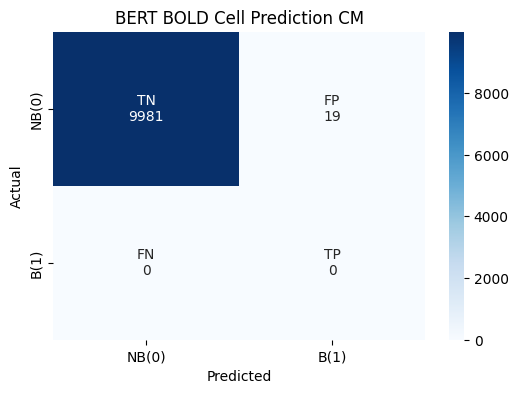


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3
0,1,1,0,1
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
9,1,1,0,1
11,1,0,0,0
12,1,1,1,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---
No bold cells in actual data.


In [9]:
binfer_one(
    trained_model,
    val_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/50_test/retrospective-review-plan-report-20150317.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,11): 0.05314663052558898926
(0,9): 0.05972302332520484924
(0,6): 0.08246020227670669556
(0,7): 0.12005262821912765503
(0,10): 0.13453236222267150879
(0,8): 0.85180610418319702148
(0,0): 0.93823748826980590820
(0,5): 0.93925249576568603516
(0,3): 0.94048088788986206055
(0,2): 0.94059479236602783203
(0,1): 0.94070690870285034180
(0,4): 0.94075530767440795898

NB to B ratio: Predicted = 9795:205 | Actual = 9988:12
Accuracy: 97.95% | Precision: 2.93% | Recall: 50.00% | F1-Score: 0.06



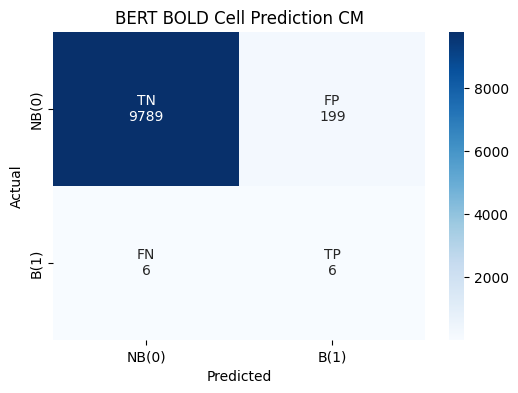


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,1,1,1,0,0,0,0,0,0
1,1,1,1,1,0,1,0,1,1,0,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0
3,1,1,0,1,1,1,0,1,1,0,0,1
4,1,1,1,1,1,1,0,1,1,0,0,1
5,1,1,1,1,0,1,0,1,1,0,0,1
6,1,1,1,1,0,1,0,1,1,0,0,1
7,1,1,0,1,1,1,0,1,1,0,1,0
8,1,1,1,1,1,1,1,1,1,0,0,0
9,1,1,0,1,1,1,0,1,1,0,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,1,1,1,1,1,1,1,1,1


In [12]:
binfer_one(
    trained_model,
    test_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)

Batch Inference: 100%|██████████| 2/2 [00:31<00:00, 15.82s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 395726:4274 | Actual = 399199:801
Accuracy: 99.13% | Precision: 18.05% | Recall: 98.14% | F1-Score: 0.30



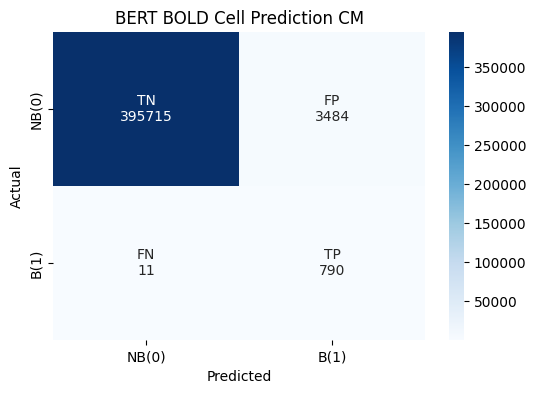

In [13]:
binfer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=20,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49372:628 | Actual = 49846:154
Accuracy: 98.95% | Precision: 20.38% | Recall: 83.12% | F1-Score: 0.33



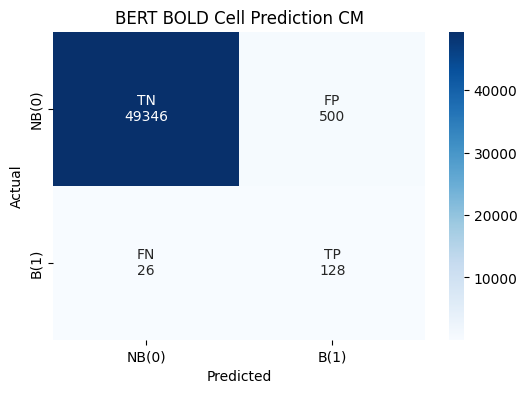

In [14]:
binfer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.36s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 48365:1635 | Actual = 49801:199
Accuracy: 96.95% | Precision: 9.42% | Recall: 77.39% | F1-Score: 0.17



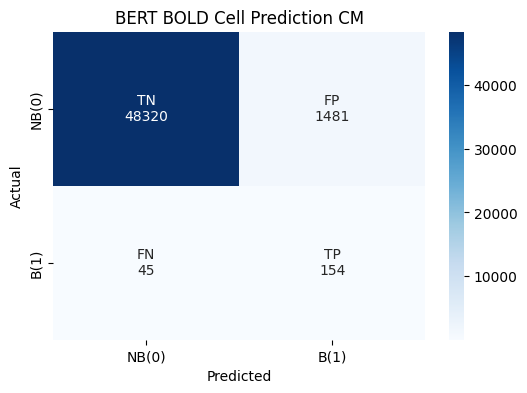

In [15]:
binfer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)